Load data

In [30]:
import numpy as np 
import cmocean
import cmocean.cm as cmo
import xarray as xr   
from pathlib import Path
from netCDF4 import Dataset
import glob
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import datetime 
from datetime import date 
import mpl_toolkits.basemap as bm
import matplotlib.animation as animation
import numpy.ma as ma
import matplotlib.cm as cm
from matplotlib.patches import Polygon
from scipy import signal, stats
import time
import cv2
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec
import warnings; warnings.simplefilter('ignore')

from functions import load_ice, trend, find_trends, plot_cartopy, decomp

# input data directory

path = Path('/extra-space1/data/tikoralukupload/cis-weekly/nc/')

# 2021
path2021 = Path('/extra-space1/data/tikoralukupload/cis-weekly/nc-for-May-2021-06-02')

# region of interest
region = 'HB'

# Projection for mapping
rot = ccrs.RotatedPole(pole_latitude=55,pole_longitude=150)

# Construct the full file name
fname = path / '{}.nc'.format(region)
fname2021 = path2021 / '{}.nc'.format(region) # 2021

### Load data into a `xarray.Dataset`:
# Note that the data is loaded lazily which means that no actual data are actually written
# into memory.
# ds = xr.open_dataset(fname, decode_times=False)
# ds2021 = xr.open_dataset(fname2021, decode_times=False)

ds = xr.open_dataset(fname)
ds2021 = xr.open_dataset(fname2021)

juld = ds.juld
juld2021 = ds2021.juld
# Combine data structures
juld = xr.concat([juld, juld2021], "juld")

# subset `xarray.Dataset` by index
# ds = ds.isel(x=slice(1700, None), y=slice(600, 1450))
# ds2021 = ds2021.isel(x=slice(1700, None), y=slice(600, 1450))

# Labrador shelf only
ds = ds.isel(x=slice(1800, 2500), y=slice(800, 1450))
ds2021 = ds2021.isel(x=slice(1800, 2500), y=slice(800, 1450))



# create shortcuts to the variables. 
lon = ds.longitude
lat = ds.latitude
land = ds.land
# E_FA = ds['E_FA']
E_CTold = ds['E_CT']
E_CT2021 = ds2021['E_CT']

E_SAold = ds['E_SA']
E_SA2021 = ds2021['E_SA']

E_CT = xr.concat([E_CTold, E_CT2021], dim="juld")
E_SA = xr.concat([E_SAold, E_SA2021], dim="juld")


## Using N_CT
N_CTold = ds['N_CT']
N_CT2021 = ds2021['N_CT']

N_CT = xr.concat([N_CTold, N_CT2021], dim="juld")


In [31]:
### Decompose time series yearly

# choose which metric to decompose 
def decompose_tseries(eggcode):
    years = juld.dt.year
    months = juld.dt.month

    years_unique = np.unique(years)

    # Clean out years
    years_unique_clean = years_unique[np.array([4,9,10,12,13,14,15,16,17,18,19,20,21,22,23,24])]
 
    
    m = np.shape(lon)[0] # shape of lon
    n = np.shape(lat)[1]
    # Calculate monthly means and subtract them from time series
    ybar = np.zeros((len(years_unique_clean),m,n))
#     area_mean = np.zeros((len(years_unique_clean)))
    darr=[]
    year_occurences = []

    cnt=0
    for yr in years_unique_clean:
        # Every year for the month defined by mon
        which = (years == yr)
        if np.sum(which) >= 1:
            # Save all observational days of the month
            inds = np.where(which)[0]
    #         date_str.append(dates[k].strftime("%Y-%m-%d"))
            # yearly means
            ybar[cnt,:,:] = np.nanmean(eggcode[inds,:,:],axis=0)
            # Subtract mean from time series
            darr.append(eggcode[inds,:,:] - np.nanmean(eggcode[inds,:,:],axis=0))
            # Indices of dates within each month
            year_occurences.append(juld[inds])
            # Area of ice
#             area_mean[cnt] = np.mean(np.count_nonzero(~np.isnan(eggcode[inds,:,:])))
            cnt +=1


    n = np.shape(lon)[1]
    m = np.shape(lon)[0]

    ### Calculate trends and anomolies
    
    ytrend = np.zeros((m,n))
    dtrend_95 = np.zeros((m,n))
    slope = np.zeros((m,n))
    intercept = np.zeros((m,n))
    
    # Calculate trends along time axis
    for i in range(m):
        for j in range(n):
            mean, tr, dt95 = trend(years_unique_clean, ybar[:,i,j])
            ytrend[i,j] = tr
            dtrend_95[i,j] = dt95
            s,b = np.polyfit(years_unique_clean,ybar[:,i,j],1)
            slope[i,j] = s
            intercept[i,j] = b

    k = len(years_unique_clean)
    anom = np.zeros((k,m,n))
    
    ### Anomolies
    
    for i in range(m):
        for j in range(n):
            anom[:,i,j] = ybar[:,i,j] - (years_unique_clean*slope[i,j] + intercept[i,j]) 

    return ybar, ytrend, anom, years_unique_clean


visualize domain

In [32]:
# Replace eggcode values for concentration with real values
A = xr.where(N_CT>9, N_CT, N_CT/10)
B = xr.where(N_CT==10, 0.95, A)
CT = xr.where(N_CT==11, 1, B)

# Replace eggcode values for thickness with real values
A = xr.where(E_SA==1, 0.05, E_SA)
B = xr.where(E_SA==4, 0.125, A)
C = xr.where(E_SA==5, 0.225, B)
D = xr.where(E_SA==7, 0.50, C)
E = xr.where(E_SA==10, 0.95, D)
F = xr.where(E_SA==11, 1.60, E)
G = xr.where(E_SA==12, 2.50, F)
HA = xr.where(E_SA>13, np.nan, G)

Call function

In [33]:
ybar_HA, ytrend_HA, anom_HA, years_unique = decompose_tseries(HA)

# Check to see if anomolies are correct - mean should be 0
plt.pcolormesh(lon,lat,np.nanmean(anom, axis=0),cmap='RdBu')
plt.colorbar()

NameError: name 'anom' is not defined

In [ ]:
# Plot yearly Anomolies

cnt=1
fig = plt.figure(figsize=(12,10), facecolor='white')
for i in np.arange(0,len(years_unique)):
    plt.subplot(5,5,cnt)
    im = plt.pcolormesh(lon, lat, anom[i,:,:], cmap='RdBu', vmin=-0.5, vmax=0.5)
#     im = plt.pcolormesh(lon, lat, ybar[i,:,:], cmap='RdBu')

    plt.title(years_unique[i])
#     plt.colorbar()
    cnt+=1
#     plt.axis('off')
    plt.xticks([], [])
    plt.yticks([], [])
    
fig.subplots_adjust(bottom=0.03, top=0.9, left=0.1, right=0.8,
                    wspace=0.1, hspace=0.2)
cb_ax = fig.add_axes([0.83, 0.08, 0.02, 0.8])
cbar = fig.colorbar(im, cax=cb_ax)
cbar.ax.tick_params(labelsize=15)
cbar.set_label('Ice thickness anomolies [m]')
# plt.tight_layout()
# plt.savefig('/home/mwang/CIS-project/figures/Jun17_anom_maps_cleaned.png')

In [ ]:
# Average thickness

cnt=1
fig = plt.figure(figsize=(12,10), facecolor='white')
for i in np.arange(0,len(years_unique)):
    plt.subplot(5,5,cnt)
    im = plt.pcolormesh(lon, lat, ybar[i])
#     im = plt.pcolormesh(lon, lat, ybar[i,:,:], cmap='RdBu')

    plt.title(years_unique[i])
#     plt.colorbar()
    cnt+=1
#     plt.axis('off')
    plt.xticks([], [])
    plt.yticks([], [])
fig.subplots_adjust(bottom=0.03, top=0.9, left=0.1, right=0.8,
                    wspace=0.1, hspace=0.2)
cb_ax = fig.add_axes([0.83, 0.08, 0.02, 0.8])
cbar = fig.colorbar(im, cax=cb_ax)
cbar.ax.tick_params(labelsize=15)
cbar.set_label('Average ice thickness [m]')
# plt.tight_layout()
# plt.savefig('/home/mwang/CIS-project/figures/Jun17_anom_maps_cleaned.png')

# Plot overall trends

In [34]:
fig = plt.figure(figsize=(10,7), facecolor='white')
ymeans_clean = ymeans[np.array([4,9,10,12,13,14,15,16,17,18,19,20,21,22,23,24])]
ymeans = np.nanmean(np.nanmean(ybar, axis=1),axis=1)
s,b = np.polyfit(years_unique, ymeans, 1)

# Remove years with no LF coded
# years_unique_clean = years_unique[np.array([4,9,10,12,13,14,15,16,17,18,19,20,21,22,23,24])]
# ymeans_clean = ymeans[np.array([4,9,10,12,13,14,15,16,17,18,19,20,21,22,23,24])]
plt.plot(years_unique, ymeans, '.-')
plt.plot(years_unique, years_unique*s + b)
plt.xticks(years_unique,rotation='vertical', fontsize=13)
# plt.plot(years_unique_clean, s*years_unique_clean + b, 'r-', label='Slope = ')
plt.yticks(fontsize=13)
plt.ylabel('Average thickness', fontsize=15)
# plt.title('Average thickness (m)')
# plt.savefig('/home/mwang/CIS-project/figures/Jun17_hA_tseries_cleaned_shelf.png', dpi=200)

NameError: name 'ybar' is not defined

<Figure size 720x504 with 0 Axes>

## Ice area

In [24]:
# Add up concentrations. ie) 0.5 means 0.5km coverage in 1 grid cell. 
cnt=0
years = juld.dt.year
area_mean = np.zeros(len(years_unique))
for yr in years_unique:
    # Every year for the month defined by mon
    which = (years == yr)
    if np.sum(which) >= 1:
        inds = np.where(which)[0]
        # Area of ice average over number of data days
        area_mean[cnt] = CT[inds].sum()/len(inds)
        cnt +=1


## Area mean

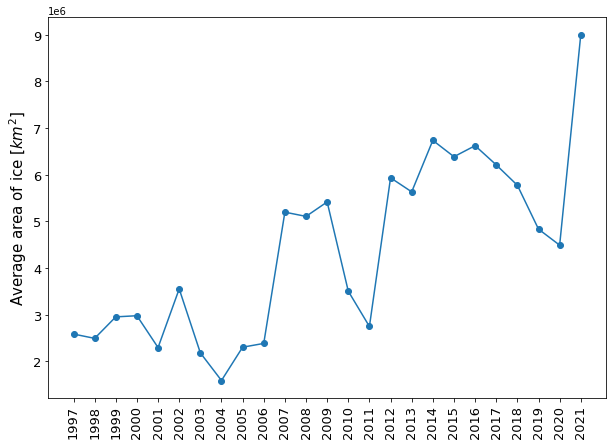

In [28]:
eggcode = CT
years_unique = np.unique(years)
inds_clean = np.array([4,9,10,12,13,14,15,16,17,18,19,20,21,22,23,24])
# Plot resampled data
ice_year_mean = eggcode.resample(juld="AS-SEP").mean(dim="juld")
# Mean of whole region
ymeans = ice_year_mean.mean(dim=["x", "y"])

# Janky but do this until I can clean it in xarray
# ymeans_clean = ymeans[inds_clean]
# years_unique_clean = years_unique[inds_clean]

fig = plt.figure(figsize=(10,7), facecolor='white')

plt.plot(years_unique, area_mean, 'o-')
plt.xticks(years_unique,rotation='vertical', fontsize=13)
# plt.plot(years_unique_clean, s*years_unique_clean + b, 'r-', label='Slope = ')
plt.yticks(fontsize=13)
plt.ylabel(r'Average area of ice [$km^2$]', fontsize=15)
# plt.savefig('/home/mwang/CIS/figures/Aug24_area_mean_jan.png', dpi=200)

# Time series of anomolies

Text(0, 0.5, 'Average ice thickness anomaly [m]')

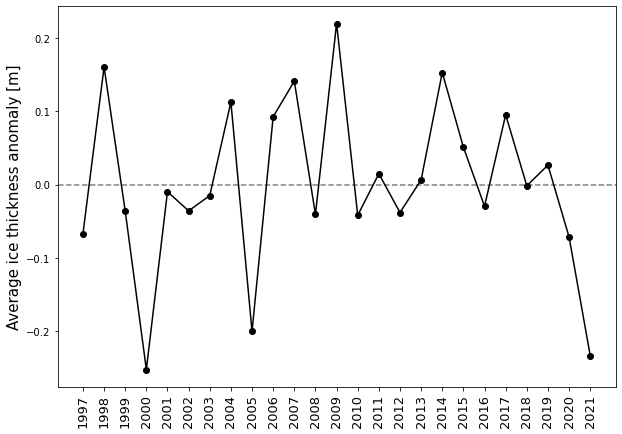

In [240]:
fig = plt.figure(figsize=(10,7), facecolor='white')
anom_HA = ymeans - (s*years_unique+b)
plt.plot(years_unique, anom_HA, 'ko-')
plt.axhline(y=0, color='k', linestyle='--',alpha=0.5)
plt.xticks(years_unique,rotation='vertical', fontsize=13)
plt.ylabel('Average ice thickness anomaly [m]', fontsize=15)

In [142]:
def plot_cartopy(ax, lon, lat):
    '''
    Set up the cartopy map with projection rotated so that Labrador coast is vertical. Input is the ax handle. 
    '''
    #Declare the land and ocean parameters
    LAND_highres = cartopy.feature.NaturalEarthFeature('physical', 'land', '10m',
    edgecolor='black',
    facecolor=('silver'),
    linewidth=1)
    OCEAN_highres = cartopy.feature.NaturalEarthFeature('physical', 'ocean', '10m',
    facecolor='dimgrey')

    #Declare the lat and lon boundaries for the map and data
    domain = [99, 99, -99, -99]
    domain[0] = np.min(lat) # South
    domain[1] = np.min(lon) # West
    domain[2] = np.max(lat) # North
    domain[3] = np.max(lon) # East
    #     domain = list(np.array(domain) + np.array([+1, +6, 0, -4]))
    domain = [53.58105923668295, -61.30979545701268, 61.589404038199575, -56.47452933956656]
    # domain = [55, -61.30979545701268, 59, -61]

    aoi_map = [domain[0], domain[2], domain[1], domain[3]]
    # Rotation for vertical coast
    rot = ccrs.RotatedPole(pole_latitude=55,pole_longitude=150)

#     # Plot results
#     transform = rot.transform_points(rot,lon,lat)
#     x_n = transform[...,0]
#     y_n = transform[...,1]

    ax.add_feature(LAND_highres,zorder=2)
    ax.add_feature(OCEAN_highres,zorder=2)
    ax.set_extent([aoi_map[2], aoi_map[3], aoi_map[0], aoi_map[1]])
    ax.coastlines(resolution='10m',linewidth=0.35,zorder=4)
    

# Compare to surface air temp from ERA5

In [261]:
# Load SST yearly 
years = range(1997,2021)
# Labrador shelf
domain = [50, -65.5+360, 64, -50+360]
t2mC_all_years = []
path = Path('/home/oliver/data/ERA/ERA5/T2M/')


for yr in years: 
    # Each nc file is one year
    fname = path / 'ERA5_T2M_{}.nc'.format(yr)
    ds = xr.open_dataset(fname)
    # # Reduce domain to Labrador shelf. Latitude must be in reverse order
    ds = ds.sel(latitude=slice(domain[2],domain[0]), longitude=slice(domain[1],domain[3]))
    # Load variables
    t2m = ds['t2m']
    lont2m = ds['longitude']
    latt2m = ds['latitude']
    time = ds['time']
    # Convert Kelvin to Celcius
    t2mC = t2m-273.15
    # Append mean of the year
    t2mC_all_years.append(t2mC.mean(dim='time'))

In [289]:
# Plot trend of yearly avergae SST
m = np.shape(t2mC_all_years)[1]
n = np.shape(t2mC_all_years)[2]
t2m_tr = np.zeros((m,n))
dtrend_95 = np.zeros((m,n))
ybar = np.zeros((m,n))

for i in range(m):
    for j in range(n):
        mean, tr, dt95 = trend(np.array(years), np.array(t2mC_all_years)[:,i,j])
        t2m_tr[i,j] = tr
        dtrend_95[i,j] = dt95
        ybar[i,j] = mean


In [1]:
fig = plt.figure(figsize=(12,8),facecolor='white')
ax = fig.add_subplot(111, projection=rot)

#Declare the land and ocean parameters
LAND_highres = cartopy.feature.NaturalEarthFeature('physical', 'land', '10m',
edgecolor='black',
facecolor=('silver'),
linewidth=1)
# OCEAN_highres = cartopy.feature.NaturalEarthFeature('physical', 'ocean', '10m',
# facecolor='dimgrey')

#Declare the lat and lon boundaries for the map and data
domain = [99, 99, -99, -99]
domain[0] = np.min(lat) # South
domain[1] = np.min(lon) # West
domain[2] = np.max(lat) # North
domain[3] = np.max(lon) # East
#     domain = list(np.array(domain) + np.array([+1, +6, 0, -4]))
domain = [53.58105923668295, -61.30979545701268, 61.589404038199575, -56.47452933956656]
# domain = [55, -61.30979545701268, 59, -61]

aoi_map = [domain[0], domain[2], domain[1], domain[3]]
# Rotation for vertical coast
rot = ccrs.RotatedPole(pole_latitude=55,pole_longitude=150)

ax.set_extent([aoi_map[2], aoi_map[3], aoi_map[0], aoi_map[1]])
ax.coastlines(resolution='10m',linewidth=1,zorder=4)


plt.pcolormesh(lont2m,latt2m,t2m_tr,transform=ccrs.PlateCarree(),zorder=2)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=15)
cbar.set_label(r'$^o$C/year',fontsize=15)
plt.title('Average yearly surface air temp trend 1997-2021',fontsize=14)
# plt.savefig('/home/mwang/CIS-project/figures/Jul22_SST_trend.png')

NameError: name 'plt' is not defined

Time series of SST average for whole region
